In [11]:
from PIL import Image
import os
import multiprocessing
from functools import partial
import logging
import progressbar
import numpy as np
import cv2
logging.basicConfig(level=logging.INFO)

In [12]:
logging.debug("Test debug")
logging.info("Test info")

INFO:root:Test info


In [13]:
def contours_worker(src_filename, dst_dir):
    try:
        mask = np.array(Image.open(src_filename))
        _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        img_contours = np.zeros_like(mask)
        for contour in contours:
            img_contours[contour[:,0,1], contour[:,0,0]] = 1
        src_basename = os.path.basename(src_filename)
        dst_basename, _ = os.path.splitext(src_basename)
        dst_filename = os.path.join(dst_dir, dst_basename + ".png")
        img_contours = Image.fromarray(img_contours)
        img_contours.save(dst_filename)
    except Exception as e:
        logging.error("Can't process image {}: {}".format(src_filename, e))

In [14]:
def iter_files_with_ext(root_dir, ext):
    """
    Iterate recursively on all files in root dir, ending with <ext>.
    :param root_dir: Directory to list.
    :param ext: Extension of the files.
    :return: absolute path of all files.
    """
    for path, sub_dirs, files in os.walk(root_dir):
        for name in files:
            if not name.startswith(".") and name.endswith(ext):
                abs_path = os.path.abspath(os.path.join(path, name))
                if os.path.isfile(abs_path):
                    yield os.path.join(path, name)

In [15]:
def contours_all(src_dir, src_ext, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    iter_images = iter_files_with_ext(src_dir, ext=src_ext)
    
    contours_worker_spec = partial(contours_worker, dst_dir=dst_dir)
    with multiprocessing.Pool() as pool, progressbar.ProgressBar(max_value=progressbar.UnknownLength) as pbar:
        for i, _ in enumerate(pool.imap_unordered(contours_worker_spec, iter_images)):
            pbar.update(i+1)

In [6]:
contours_all("../data/train_masks/", ".gif", "../data/contours/")

| 5088 Elapsed Time: 0:00:55                                                   


In [114]:
mask = np.array(Image.open("../data/train_masks/00087a6bd4dc_04_mask.gif"))
contours = np.array(Image.open("../data/contours/00087a6bd4dc_04_mask.png"))

In [115]:
def get_contours(mask):
    """
    Get a binary image with the inside and outside contours, each of with tickness
    """
    _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_inside_contours = np.zeros_like(mask)
    img_outside_contours_tmp = np.zeros_like(mask)
    cv2.drawContours(img_inside_contours, contours, -1, (1, 1, 1), 1)
    cv2.drawContours(img_outside_contours_tmp, contours, -1, (1, 1, 1), 2)
    img_outside_contours = (img_outside_contours_tmp != 0) & (mask == 0)
    img_inside_outside = (img_inside_contours != 0) | img_outside_contours          
    return img_inside_outside.astype(np.uint8)

In [116]:
img_c = get_contours(mask)

In [117]:
im_rgb = np.zeros(mask.shape + (3, ), dtype=np.uint8)
im_rgb[..., 0] = mask * 255
im_rgb[..., 1] = mask * 255
im_rgb[..., 2] = img_c * 255

In [118]:
Image.fromarray(im_rgb).save("../data/test_contours.png")

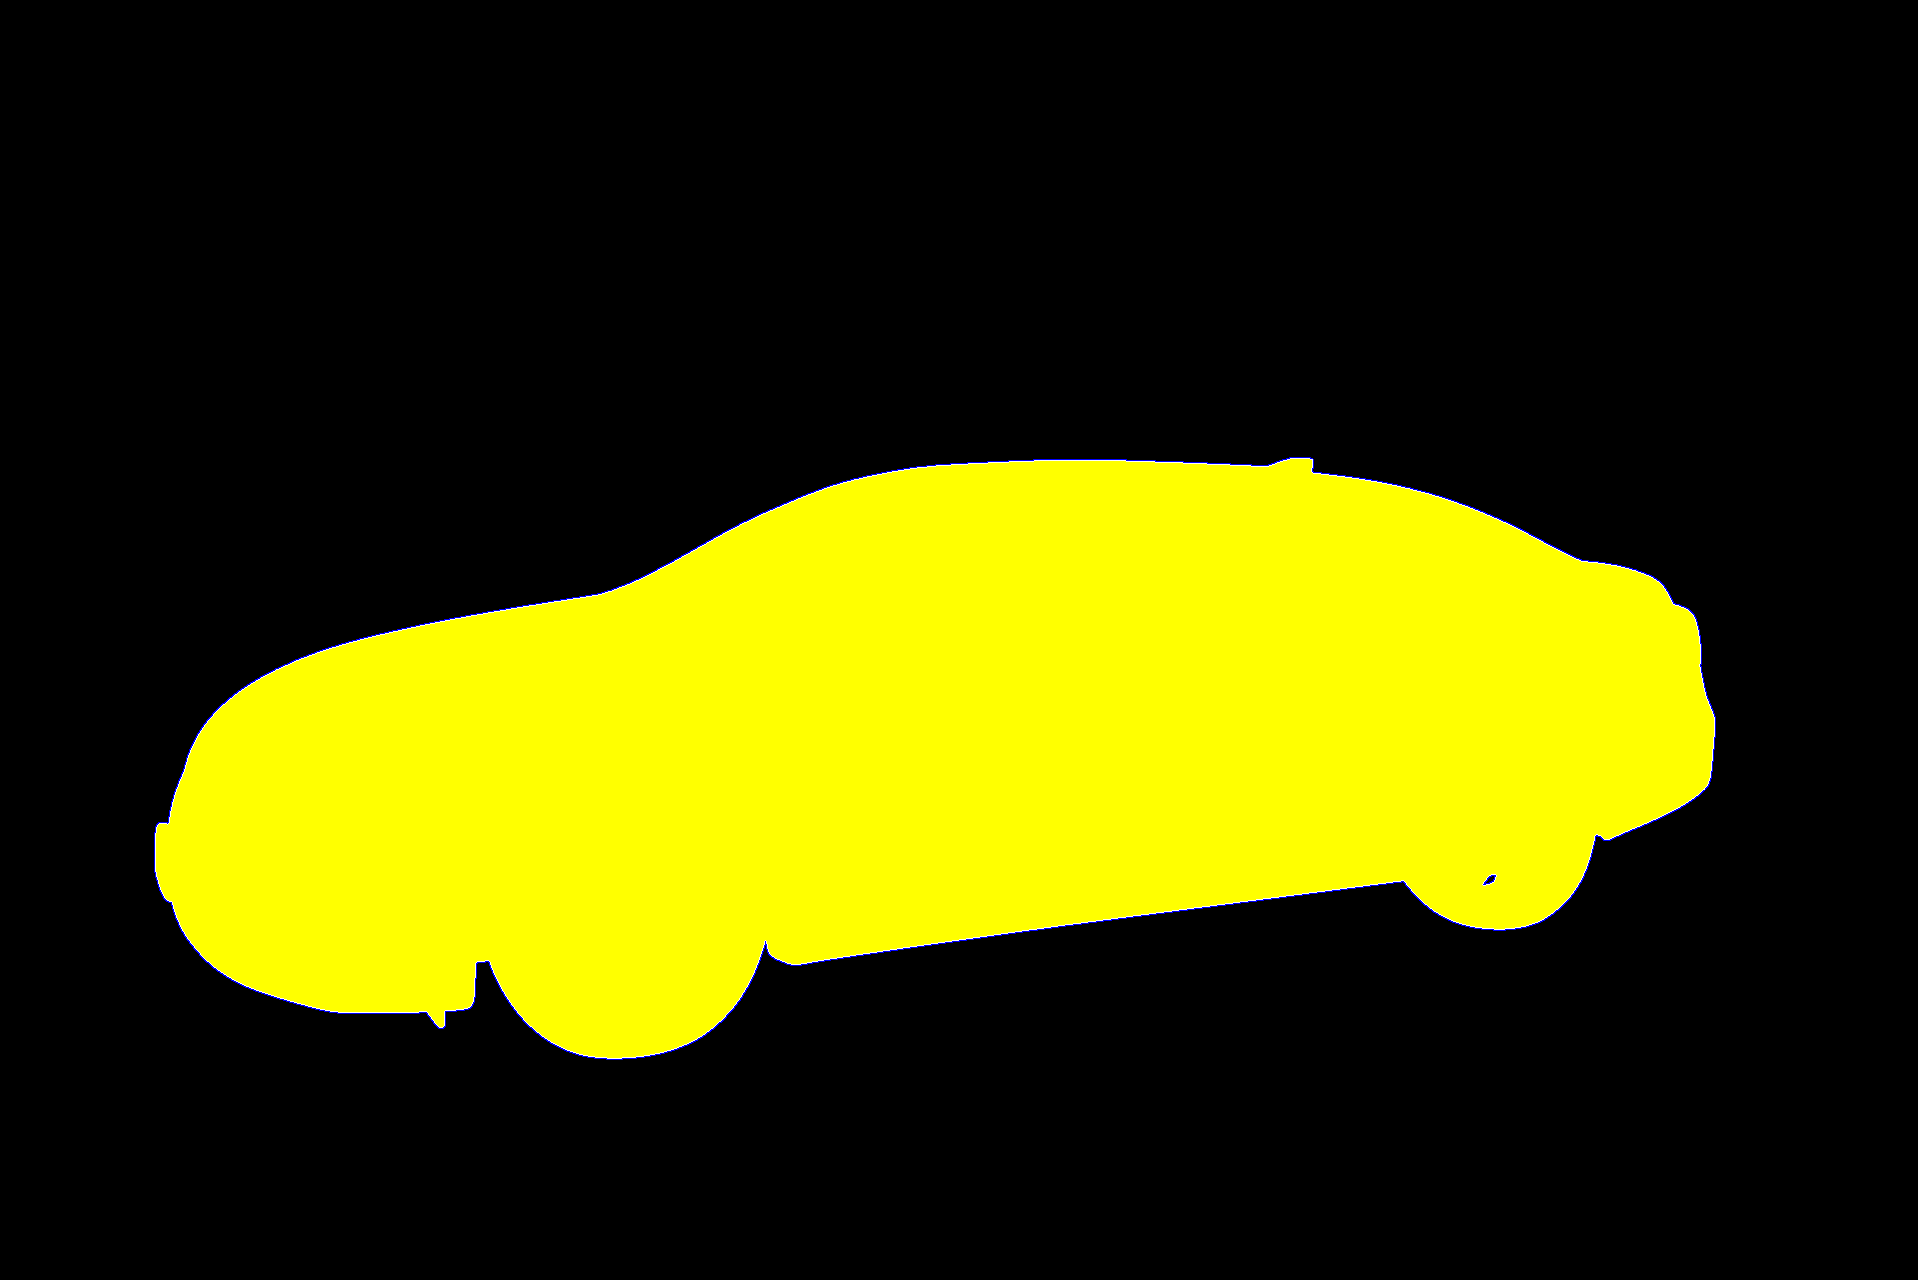

In [119]:
Image.fromarray(im_rgb)

In [18]:
mask = np.array(mask)

In [32]:
_, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_contours = np.zeros_like(mask)
for contour in contours:
    img_contours[contour[:,0,1], contour[:,0,0]] = 1

In [54]:
img_contours = np.zeros_like(mask)
cv2.drawContours(img_contours, contours, 0, (255, 255, 255), 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [55]:
Image.fromarray(img_contours).save("../data/contours_1.png")


In [56]:
im_rgb = np.zeros(mask.shape + (3, ), dtype=np.uint8)
im_rgb[..., 0] = mask * 255
im_rgb[..., 1] = mask * 255
im_rgb[..., 2] = img_contours

In [57]:
Image.fromarray(im_rgb).save("../data/contours_2.png")